# Vector centrality

In [1]:
import numpy as np
import xgi
import networkx as nx
import copy
from collections import OrderedDict
from itertools import combinations
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from scipy.stats import kendalltau as KT

from hyperfunctions import *

Example from Figure 1 of the "Vector Centrality in Networks with Higher-Order Interactions" paper

The hypergraph has [0, 1, 2, 3, 4] nodes and ['a', 'b', 'c', 'd'] edges


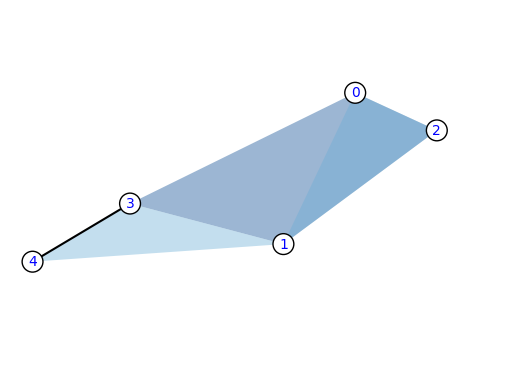

In [2]:
hyperedge_dict = {'a': [0,1,2], 'b': [0,1,2,3], 'c': [1,3,4], 'd': [3,4]}
H = xgi.Hypergraph(hyperedge_dict)
print(f"The hypergraph has {H.nodes} nodes and {H.edges} edges")
xgi.draw(H, node_labels=True, font_color_nodes="blue")

In [3]:
def line_graph(H):
    '''Constructs the line graph of a hypergraph
    :param H :: xgi.Hypergraph:
    :return LG :: nx.Graph:
    ''' 
    
    # Initialize the line graph and its nodes (associated to hyperedges)
    LG = nx.Graph()

    edge_label_dict = {tuple(edge):index for index, edge in enumerate(H.edges.members())}
    LG.add_nodes_from(edge_label_dict.values())
    
    # Connect two nodes if the intersection of their hyperedges is not empty
    for edge1, edge2 in combinations(H.edges.members(), 2):
        if edge1.intersection(edge2):
            LG.add_edge(edge_label_dict[tuple(edge1)], edge_label_dict[tuple(edge2)])

    return LG

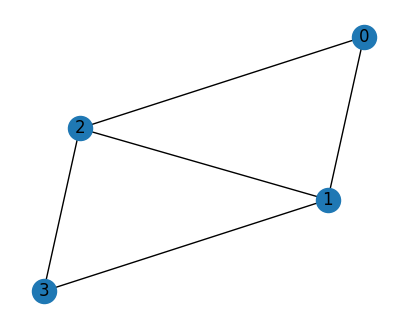

In [4]:
fig, ax = plt.subplots(1,1, figsize=(5,4))

LG = line_graph(H)
nx.draw(LG, ax=ax, with_labels=True)

In [5]:
def vector_centrality(H):
    '''Compute the vector centrality of nodes in hypergraphs
    :param H :: xgi.Hypergraph:
    :return vc :: dict:
    '''

    # Construct the line graph and compute its eigenvector centrality 
    LG = line_graph(H)
    LGcent = nx.eigenvector_centrality(LG)

    # Initialize the vector centrality dictionary
    vc = {node: [] for node in H.nodes}

    # Get hyperedge indices and dimensions
    edge_label_dict = {tuple(edge):index for index, edge in enumerate(H.edges.members())}
    hyperedge_dims = {tuple(edge):len(edge) for edge in H.edges.members()} 

    # Maximum dimension of the hyperedges
    D = np.max(list(hyperedge_dims.values()))

    for k in range(2, D+1):
        
        print(f"## K {k} ##")
        c_i = np.zeros(len(H.nodes))

        # Hyperedges of dimension K
        for edge, _ in list(filter(lambda x: x[1] == k, hyperedge_dims.items())):
            
            print(f"##### Edge {edge} #####")
        
            # Sum the centrality contribution to its hyperedges
            for node in edge:
                print(f"------- node {node} in edge -------")
                try:
                    c_i[node] += LGcent[edge_label_dict[edge]]
                except IndexError:
                    print('An index error was triggered.')
                    raise Exception('Nodes must be written with the Pythonic indexing (0,1,2...)')
        # Weight
        c_i *= 1/k

        # Append to dictionary
        for node in H.nodes:
            vc[node].append(c_i[node])

    return vc


In [6]:
H.edges.members()

[{0, 1, 2}, {0, 1, 2, 3}, {1, 3, 4}, {3, 4}]

In [7]:
vc = vector_centrality(H)

## K 2 ##
##### Edge (3, 4) #####
------- node 3 in edge -------
------- node 4 in edge -------
## K 3 ##
##### Edge (0, 1, 2) #####
------- node 0 in edge -------
------- node 1 in edge -------
------- node 2 in edge -------
##### Edge (1, 3, 4) #####
------- node 1 in edge -------
------- node 3 in edge -------
------- node 4 in edge -------
## K 4 ##
##### Edge (0, 1, 2, 3) #####
------- node 0 in edge -------
------- node 1 in edge -------
------- node 2 in edge -------
------- node 3 in edge -------


In [8]:
vc

{0: [0.0, 0.14505405756676099, 0.1393363474319356],
 1: [0.0, 0.3308358541426751, 0.1393363474319356],
 2: [0.0, 0.14505405756676099, 0.1393363474319356],
 3: [0.21758108635014148, 0.18578179657591412, 0.1393363474319356],
 4: [0.21758108635014148, 0.18578179657591412, 0.0]}